In [1]:
import time
from functools import partial
from IPython.display import display
from itertools import product

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, roc_auc_score

from utils import (
    load, 
    transform_datetime_features,
    transform_data,
    make_predictions,
    predict,
    root_mean_squared_error,
    pprint
)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/lightgbm/__init__.py:45: FutureWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS will be built by the Apple Clang compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you won't need to install the gcc compiler anymore.
Instead of that, you'll need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", FutureWarning)


In [2]:
def assess_lightgbm(params, task, folds=10):
#     print('----------------------------\n', model, '\n')
    pprint(f'Task: {task}',)
    start_time = time.time()
    train_err, valid_err, test_err = [], [], []
    for i in range(folds):
        df_x, target = load(task, 'train')
        _, y_test = load(task, 'test-target')
        x_test, _ = load(task, 'test')

        x_train, x_valid, y_train, y_valid = train_test_split(df_x, target, test_size=.2, random_state=i * 1234)

        pipeline, x_train = transform_data(x_train, y_train)

#         model.fit(x_train, y_train)
        model = lgb.train(params, lgb.Dataset(x_train, label=y_train), 600)
        pipeline.append(partial(make_predictions, model=model))

        if task < 4:
            train_predictions = make_predictions(x_train, model)
            train_rmse = root_mean_squared_error(y_train, train_predictions)
            train_err.append(train_rmse)

            valid_predictions = predict(x_valid, pipeline)
            valid_rmse = root_mean_squared_error(y_valid, valid_predictions)
            valid_err.append(valid_rmse)

            test_predictions = predict(x_test, pipeline)
            test_rmse = root_mean_squared_error(y_test, test_predictions)
            test_err.append(test_rmse)
        else:
            train_predictions = make_predictions(x_train, model)
            train_auc = roc_auc_score(y_train, train_predictions)
            train_err.append(train_auc)

            valid_predictions = predict(x_valid, pipeline)
            valid_auc = roc_auc_score(y_valid, valid_predictions)
            valid_err.append(valid_auc)

            test_predictions = predict(x_test, pipeline)
            test_auc = roc_auc_score(y_test, test_predictions)
            test_err.append(test_auc)

    #     print('----------------------------')
    #     print(f'Train RMSE: {train_rmse}, \nValidation RMSE: {valid_rmse}, \nTest RMSE: {test_rmse}')
    #     print('----------------------------')
    df_err = pd.DataFrame(dict(train=train_err, valid=valid_err, test=test_err))
    display(df_err.mean())
    df_err.plot(kind='bar')
    plt.show()
    print('Elapsed Time: ', time.time() - start_time)
    print('----------------------------')
    return df_err

In [3]:
params =  {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression', #if args.mode == 'regression' else 'binary',
    'metric': 'rmse',
    "learning_rate": 0.01,
    "num_leaves": 200,
    "feature_fraction": 0.70,
    "bagging_fraction": 0.70,
    'bagging_freq': 4,
    "max_depth": -1,
    "verbosity" : -1,
    "reg_alpha": 0.3,
    "reg_lambda": 0.1,
    #"min_split_gain":0.2,
    "min_child_weight":10,
    'zero_as_missing':True,
    'num_threads': 4,
}

------------------------------------
Task: 1
----------***************-----------


test     11.527752
train     6.299530
valid    10.644853
dtype: float64

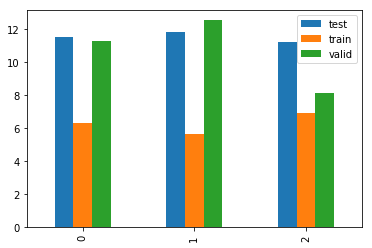

Elapsed Time:  2.43400502204895
----------------------------


In [4]:
metrics = []
for task in range(1, 2):
    metrics.append(assess_lightgbm(params, task=task, folds=3))

In [20]:
pd.concat(metrics)

,test,train,valid
0,11.519624,6.327326,11.271890
1,11.851040,5.628243,12.539735
2,11.212593,6.943022,8.122935
0,1.218781,0.741120,1.018673
1,1.217567,0.751986,0.967375
2,1.204746,0.750125,0.964003
0,110035.772947,88199.792336,97439.952112
1,109947.894899,88399.819093,96541.986741
2,109942.542935,88315.500850,97210.469681
0,0.770701,0.896876,0.772461


In [2]:
task = 1
df_x, target = load(task, 'train')
_, y_test = load(task, 'test-target')
x_test, _ = load(task, 'test')

x_train, x_valid, y_train, y_valid = train_test_split(df_x, target, test_size=.2, random_state=1234)

pipeline, x_train = transform_data(x_train, y_train)

------------------------------------
['datetime_0']
----------***************-----------


In [3]:
x_train.columns

Index(['number_0', 'number_1', 'number_2', 'number_3', 'number_4', 'number_5',
       'number_6', 'number_7', 'number_8', 'number_9', 'number_10',
       'number_11', 'number_12', 'number_13', 'number_14', 'number_15',
       'number_16', 'number_17', 'number_18', 'number_19', 'number_20',
       'number_21', 'number_22', 'number_23', 'number_24', 'number_25',
       'number_26', 'number_27', 'number_28', 'number_29', 'number_30',
       'number_31', 'number_32', 'number_33', 'number_34', 'number_35',
       'number_36', 'number_37', 'number_38', 'dt_number_weekday_datetime_0',
       'dt_number_month_datetime_0', 'dt_number_day_datetime_0',
       'dt_number_hour_of_week_datetime_0',
       'onehot_number_5=0.7272727272727273',
       'onehot_number_5=0.3636363636363637',
       'onehot_number_5=0.18181818181818185',
       'onehot_number_5=0.4545454545454545',
       'onehot_number_5=0.6363636363636364', 'onehot_number_5=1.0',
       'onehot_number_5=0.9090909090909092'],
      dtype

In [4]:
pipeline

[functools.partial(<function transform_datetime_features at 0x113f96730>, datetime_columns=['datetime_0']),
 functools.partial(<function drop_columns at 0x113f96840>, cols=['dt_number_hour_datetime_0', 'dt_number_minute_of_day_datetime_0']),
 functools.partial(<function one_hot_encoding at 0x113f96950>, categorical={'number_5': array([ 0.72727273,  0.36363636,  0.18181818,  0.45454545,  0.63636364,
         1.        ,  0.90909091])}),
 functools.partial(<function fill_missings at 0x113f96a60>, columns=[]),
 functools.partial(<function keep_columns at 0x113f96b70>, columns=['number_0', 'number_1', 'number_2', 'number_3', 'number_4', 'number_5', 'number_6', 'number_7', 'number_8', 'number_9', 'number_10', 'number_11', 'number_12', 'number_13', 'number_14', 'number_15', 'number_16', 'number_17', 'number_18', 'number_19', 'number_20', 'number_21', 'number_22', 'number_23', 'number_24', 'number_25', 'number_26', 'number_27', 'number_28', 'number_29', 'number_30', 'number_31', 'number_32', 